<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor


In [2]:
#считаю датасет 
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


(26496, 2)

колонка datetime имеет неверный формат

In [4]:
#заменую тип данных в datetime    
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
#установлю индекс таблицы равным столбцу datetime
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Данные предоставленыс 1 марта 2018 года по 31 августа 2018 года с разницей в 10 минут

In [7]:
#проверю хронологию расположения даты и время
data = data.sort_index() 
print(data.index.is_monotonic)

True


Порядок соблюден

In [8]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


В каждые 10 минут заказов:
- максимальное кол-во 119
- среднее кол-во 14

Не вижу аномальных значений

In [9]:
#проверю на пропуски
data.isna().sum()

num_orders    0
dtype: int64

In [10]:
data.shape

(26496, 1)

пропусков нет

### Вывод

- данные загружены и проведена предварительная подготовка
- установлю индекс таблицы равным столбцу datetime
- заменила тип данных в дате и времени на datetime
- пропусков в данных нет
- выбросов и аномальных значений не выявлено
- данные предоставленыс 1 марта 2018 года по 31 августа 2018 года с разницей в 10 минут
- в дате и времени соблюден хронологический порядок

## Анализ

<AxesSubplot:xlabel='datetime'>

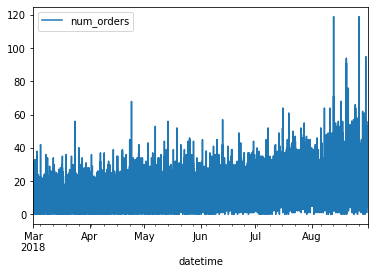

In [11]:
#построю график временного ряда
data.plot()

Кол-во заказаов увеличивается с начала августа с интервалом наблюдений в 10 минут. Чтобы сократить кол-во наблюдений, сокращу шаг до 1 часа при помощи рессеплирования. К тому же, для модели нужен почасовой прогноз.

<AxesSubplot:xlabel='datetime'>

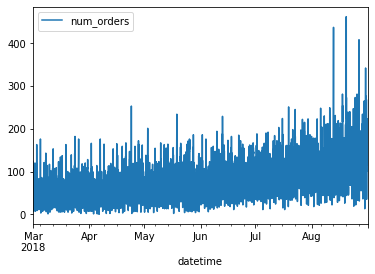

In [12]:
#изменю шаг наблюдений до 1 часа и построю график средних заказов таки по часам
data.sort_index(inplace=True)
data = data.resample('1H').sum()# < напишите код здесь >
data.plot()

In [13]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Чтобы во временном ряду снизить колебания, применю скользящее среднее.

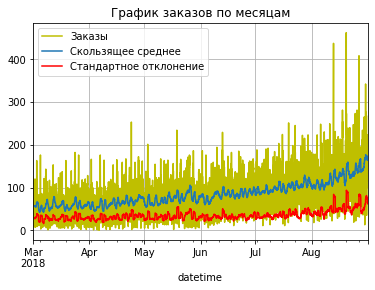

In [14]:
#Построю 'rolling_mean' скользящее среднее с размером окна, равным 24 часа и стандартное отклонение

data.plot(color='y')
data['num_orders'].rolling(24).mean().plot(grid=True)
data['num_orders'].rolling(24).std().plot(grid=True, color='r')

plt.title('График заказов по месяцам')
plt.legend(['Заказы','Скользящее среднее','Стандартное отклонение'])
plt.show()

По средним значениями можно также убедиться в росте заказов по часам

Чтобы лучше понимать временной ряд, построю тренды и сезонность

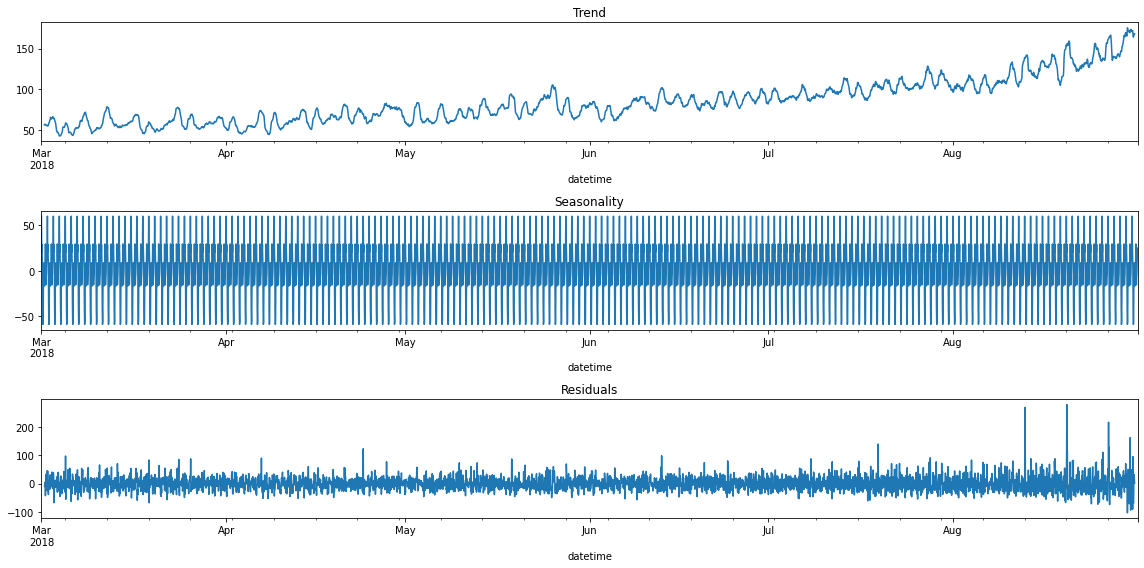

In [15]:
#Разложу временной ряд на тренд и сезонную компоненту и построю график
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(16, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Тренд растет ежемесячно

Text(0.5, 1.0, 'Сезонность заказов в течение первых 7 дней августа')

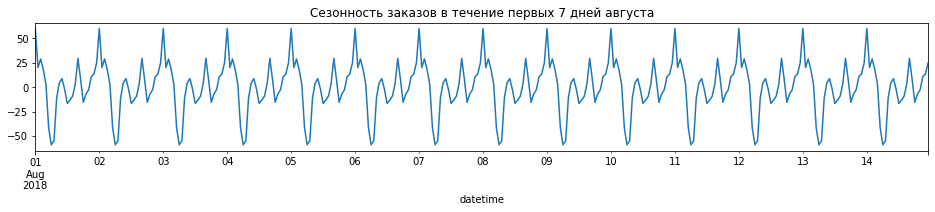

In [16]:
#Рассмотрю сезонность заказов в первые две недели августа.

decomposed_day = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed_day.seasonal['2018-08-01':'2018-08-14'].plot(ax=plt.gca())
plt.title("Сезонность заказов в течение первых 7 дней августа")

Каждый день есть пики по кол-ву заказаов, посмторю сезонность внутри пары дней

<AxesSubplot:title={'center':'Сезонность заказов за два дня'}, xlabel='datetime'>

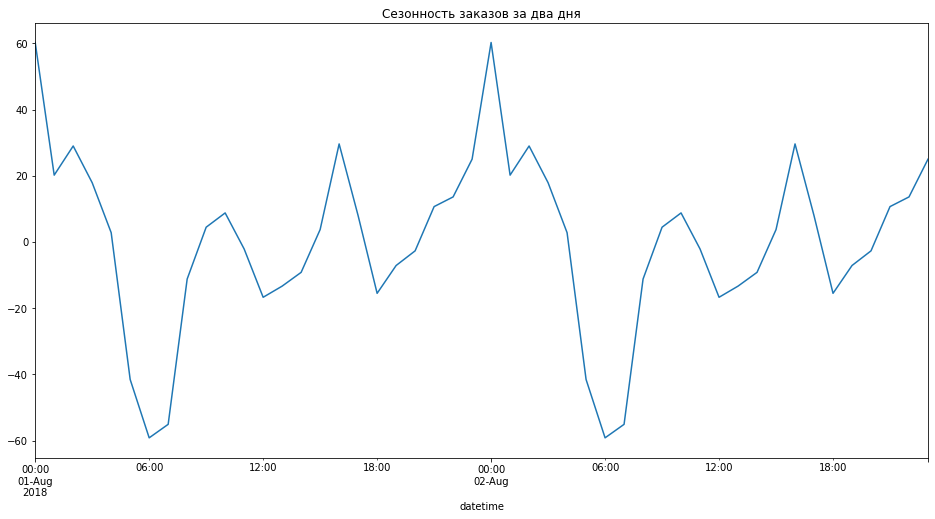

In [17]:
plt.figure(figsize=(16,8))
plt.title("Сезонность заказов за два дня")
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())

Пик приходится на 00 часов и 16:00, спад в 6:00 часов утра

### Вывод

Проведя аналаизы, были отмечены следующие наблюдения:
1. кол-во заказов растет ежемесячно
2. сезонность меняется в зависимости от времени: пик приходтся на ночное время и в районе 16:00-17:00, самый низкий спрос на такси в 6:00 утра. 

## Обучение

Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

Для обучения создам признаки: напишу функцию make_features, чтобы прибавить к таблице четыре новых календарных признака: год, месяц, день и день недели и два расчетных: отстающие значения и скользящее среднее.

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    #Вычислю отстающие значения. 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    #Вычислю скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
#Применю функцию к датасету
make_features(data, 6, 6)
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [20]:
#Разобью датасет на обучающую и тестовую выборки. 
train, test  = train_test_split(data, test_size = 0.1, shuffle=False)
#Из обучающей выборки удалю строки с пропусками.
train = train.dropna()

#проверю пропорции
print(train.shape)
print(test.shape)

(3968, 10)
(442, 10)


In [21]:
# выделю признаки и целевой признак
features_train = train.drop(['num_orders'], axis =1) 
target_train = train['num_orders'] 
 
features_test = test.drop(['num_orders'], axis=1) 
target_test = test['num_orders'] 

In [22]:
#для подбора гиперпараметров и сохранения хронологии временного рядf буду испольлзовать TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# LinearRegression

In [23]:
%%time

model_lr = LinearRegression()

param_lr = {'normalize':[True, False],
              'fit_intercept':[True, False]}

grid_lr = RandomizedSearchCV(model_lr, param_lr, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=12345)
grid_lr.fit(features_train, target_train)

rsme_lr = (- grid_lr.best_score_)**0.5

print('Лучшие параметры для Линейной регрессии:', grid_lr.best_params_)
print('RMSE для Линейной регрессии', rsme_lr)
print()

Лучшие параметры для Линейной регрессии: {'normalize': True, 'fit_intercept': False}
RMSE для Линейной регрессии 34.381312147800486

CPU times: user 122 ms, sys: 44.5 ms, total: 166 ms
Wall time: 148 ms


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Дерево решений

In [24]:
%%time
model_dt = DecisionTreeRegressor(random_state=42)

param_dt = {'max_depth': range(2, 10)}

grid_dt = GridSearchCV(model_dt, 
                    param_grid=param_dt,
                    cv=tscv,  
                    scoring='neg_mean_squared_error',  
                    n_jobs=-1, 
                    verbose=1)

grid_dt.fit(features_train, target_train)

rsme_dt = (- grid_dt.best_score_)**0.5

print('Лучшие параметры для Дерева решений:', grid_dt.best_params_)
print('RMSE для Дерева решений', rsme_dt)
print()

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучшие параметры для Дерева решений: {'max_depth': 8}
RMSE для Дерева решений 32.63847531429795

CPU times: user 326 ms, sys: 34.2 ms, total: 360 ms
Wall time: 404 ms


# CatBoost

In [25]:
%%time
param_cb = {
    'iterations': [100, 300],
    'depth': [5, 10]}

model_cb = CatBoostRegressor(verbose=200, early_stopping_rounds=50, random_state=12345, loss_function='RMSE')
grid_cb = GridSearchCV(estimator = model_cb, param_grid=param_cb, cv=tscv, scoring='neg_mean_squared_error')

#обучу CatBoots
grid_cb.fit(features_train, target_train)

rsme_cb = (- grid_cb.best_score_)**0.5

print('Лучшие параметры для CatBoots:', grid_cb.best_params_)
print('RMSE для CatBoots', rsme_cb)
print()

Learning rate set to 0.265845
0:	learn: 26.0290563	total: 51ms	remaining: 5.04s
99:	learn: 10.6901936	total: 146ms	remaining: 0us
Learning rate set to 0.296614
0:	learn: 28.2563618	total: 2.03ms	remaining: 201ms
99:	learn: 14.3312156	total: 131ms	remaining: 0us
Learning rate set to 0.316238
0:	learn: 30.0216989	total: 1.63ms	remaining: 162ms
99:	learn: 15.9557462	total: 143ms	remaining: 0us
Learning rate set to 0.108825
0:	learn: 27.8851994	total: 1.04ms	remaining: 310ms
200:	learn: 11.5634886	total: 192ms	remaining: 94.7ms
299:	learn: 9.3888026	total: 285ms	remaining: 0us
Learning rate set to 0.12142
0:	learn: 30.3037932	total: 1.86ms	remaining: 556ms
200:	learn: 15.0555360	total: 277ms	remaining: 137ms
299:	learn: 13.3749347	total: 436ms	remaining: 0us
Learning rate set to 0.129454
0:	learn: 32.2180164	total: 1.64ms	remaining: 490ms
200:	learn: 16.7808287	total: 322ms	remaining: 158ms
299:	learn: 15.3128299	total: 483ms	remaining: 0us
Learning rate set to 0.265845
0:	learn: 25.705660

In [33]:
#создам сводную таблицу, чтобы сравнить метрики
results = {
    'Model' : ['Линейна регрессия', 'RandomForestRegressor', 'CatBoost'],
    'RMSE' :[rsme_lr,  rsme_dt, rsme_cb],
    'Время обучения: sec': pd.Series([0.148, 0.404, 34])
}
display(pd.DataFrame(results))

,Model,RMSE,Время обучения: sec
0,Линейна регрессия,34.381312,0.148
1,RandomForestRegressor,32.638475,0.404
2,CatBoost,28.787940,34.000


Лучшая модель по rsme CatBoost 

### Вывод

- Для обучения создала новые признаки при помощи функцию make_features
- Для подбора гиперпараметров и сохранения хронологии временного ряда испольльзовала TimeSeriesSplit
- Построила и подобрала гиперпараметры для 3-х моделей
- После сравнения метрик, лучшая модель оказалась CatBoost

## Тестирование

In [34]:
#Проведу тестирование на лучшей модели CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, iterations=300, depth=5, random_state=12345)
model.fit(features_train, target_train)

pred = model.predict(features_test)

rmse = mean_squared_error(target_test, pred, squared=False)

print('RMSE для CatBoostRegressor составляет', rmse)

0:	learn: 36.9860674	total: 1.67ms	remaining: 501ms
1:	learn: 35.5715977	total: 3.37ms	remaining: 502ms
2:	learn: 34.5234125	total: 4.98ms	remaining: 493ms
3:	learn: 33.3239311	total: 6.57ms	remaining: 486ms
4:	learn: 32.3059291	total: 8.01ms	remaining: 473ms
5:	learn: 31.4845447	total: 9.49ms	remaining: 465ms
6:	learn: 30.6915495	total: 10.9ms	remaining: 455ms
7:	learn: 30.0960076	total: 12.3ms	remaining: 449ms
8:	learn: 29.5368483	total: 13.8ms	remaining: 445ms
9:	learn: 29.0983411	total: 15.2ms	remaining: 442ms
10:	learn: 28.6020495	total: 16.9ms	remaining: 444ms
11:	learn: 28.3340387	total: 18.4ms	remaining: 442ms
12:	learn: 27.9118172	total: 19.9ms	remaining: 440ms
13:	learn: 27.5626584	total: 21.3ms	remaining: 436ms
14:	learn: 27.2477045	total: 22.8ms	remaining: 433ms
15:	learn: 27.0467469	total: 24.2ms	remaining: 430ms
16:	learn: 26.8153165	total: 25.6ms	remaining: 426ms
17:	learn: 26.6738036	total: 27ms	remaining: 423ms
18:	learn: 26.5114069	total: 28.5ms	remaining: 421ms
19:	l

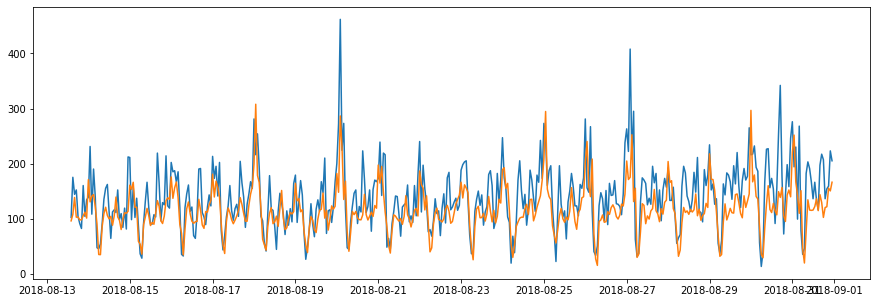

In [35]:
#Сравним предсказанные значения с фактическими
plt.figure(figsize=(15, 5))
plt.plot(target_test.index, target_test, target_test.index, pred)
plt.show()

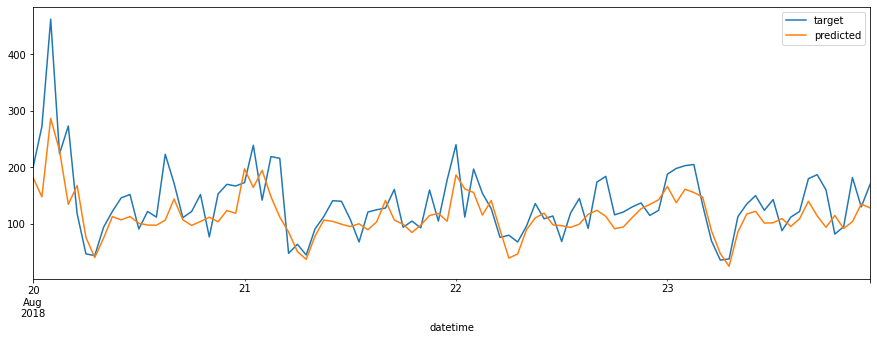

In [36]:
#Сравним предсказанные значения с фактическими на более коротком промежутке
data_control = pd.DataFrame(index=target_test.index, columns=['target'])
data_control['target'] = target_test
data_control['predicted'] = pred
data_control['2018-08-20':'2018-08-23'].plot(figsize=(15, 5))
plt.show()

Предсказания не значительно отличаются от фактических значений, все сезонные пики и тренды сохраняются.

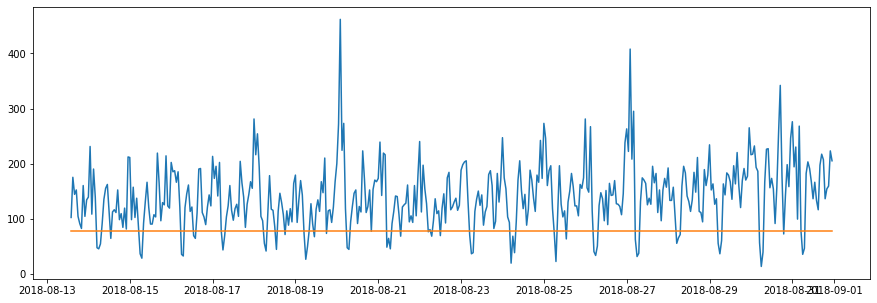

RMSE для DummyRegressor 84.73052703029548


In [37]:
model_dr = DummyRegressor()
model_dr.fit(features_train, target_train)
pred = model_dr.predict(features_test)
plt.figure(figsize=(15, 5))
plt.plot(target_test.index, target_test, target_test.index, pred)
plt.show()
rmse = mean_squared_error(target_test, pred, squared=False)

print('RMSE для DummyRegressor', rmse)

Модель адекватна

## Общий вывод

1. Данные загружены и проведена предварительная подготовка
2. При проведении аналаиза, был отмечен рост тренда кол-ва закзаов и установлены сезонные пики нагрузки такси в течении дня
3. Для составления прогноза по кол-ву заказов в следующем часе, построено 3 модели
4. Лучшая модель CatBoots была протестирована и оценена на адекватность

